# **Water Tank Management Model**

## Imports

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

## File Names and Location

In [17]:
training_data_file = "data/training_dataset_03.csv"
water_pump_model = "model/aqua_man_model.pkl"
water_pump_scaler = "model/aqua_man_scaler.pkl"
leak_detection_model = "model/leak_detector_model.pkl"
leak_detection_scaler = "model/leak_detector_scaler.pkl"

## Load and Prepare Data

In [18]:
print("\n=== Loading and Preparing Data ===")
try:
    df = pd.read_csv(training_data_file)
except FileNotFoundError:
    print("Error: 'training_dataset_01.csv' not found.")
    exit()


=== Loading and Preparing Data ===


### Convert timestamp

In [19]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df.dropna(subset=['timestamp'], inplace=True)
df['hour'] = df['timestamp'].dt.hour

print(f"Data loaded successfully with {len(df)} valid rows.")
print("=" * 50)

Data loaded successfully with 1765 valid rows.


## Model 1: Pump Control (KNN)

In [20]:
print("\n--- Training Model 1: Pump Control (KNN) ---")


--- Training Model 1: Pump Control (KNN) ---


### Features & target

In [21]:
X_pump = df[['water_level_percent']]
y_pump = df['pump_signal_target']

### Split

In [22]:
X_train_pump, X_test_pump, y_train_pump, y_test_pump = train_test_split(
    X_pump, y_pump, test_size=0.3, random_state=42
)

### Scale features

In [23]:
scaler_pump = StandardScaler()
X_train_pump_scaled = scaler_pump.fit_transform(X_train_pump)
X_test_pump_scaled = scaler_pump.transform(X_test_pump)

### Train KNN

In [24]:
pump_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
pump_model.fit(X_train_pump_scaled, y_train_pump)
print("Pump control KNN model training complete.")

Pump control KNN model training complete.


### Save model & scaler

In [25]:
joblib.dump(pump_model, water_pump_model)
joblib.dump(scaler_pump, water_pump_scaler)
print(f"Saved {water_pump_model} and {water_pump_scaler}.")

Saved model/aqua_man_model.pkl and model/aqua_man_scaler.pkl.


### Evaluate

In [26]:
y_pred_pump = pump_model.predict(X_test_pump_scaled)
accuracy_pump = accuracy_score(y_test_pump, y_pred_pump)
print(f"Pump Model Accuracy: {accuracy_pump:.4f}")

print("\nPump Classification Report:")
print(classification_report(y_test_pump, y_pred_pump, target_names=['Pump OFF (0)', 'Pump ON (1)']))

Pump Model Accuracy: 0.9302

Pump Classification Report:
              precision    recall  f1-score   support

Pump OFF (0)       0.95      0.93      0.94       325
 Pump ON (1)       0.90      0.93      0.91       205

    accuracy                           0.93       530
   macro avg       0.92      0.93      0.93       530
weighted avg       0.93      0.93      0.93       530



### Confusion Matrix

Saved confusion matrix as 'pump_knn_confusion_matrix.png'.


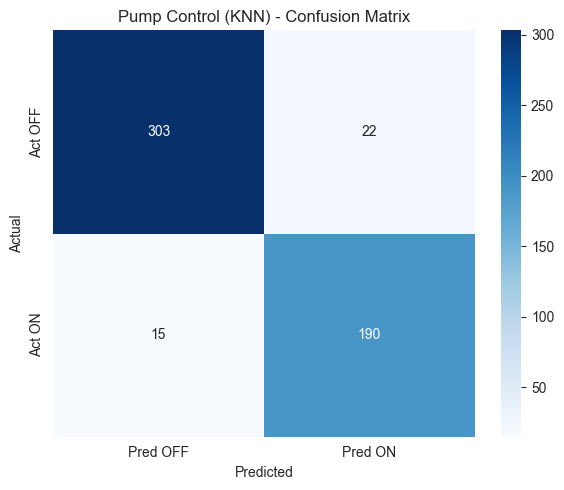

In [27]:
cm_pump = confusion_matrix(y_test_pump, y_pred_pump)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_pump, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred OFF', 'Pred ON'], yticklabels=['Act OFF', 'Act ON'])
plt.title('Pump Control (KNN) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('model/pump_knn_confusion_matrix.png')
print("Saved confusion matrix as 'pump_knn_confusion_matrix.png'.")
print("=" * 50)

## Model 2: Leak Detection (KNN)

In [28]:
print("\n--- Training Model 2: Leak Detection (KNN) ---")


--- Training Model 2: Leak Detection (KNN) ---


### Features & target

In [29]:
X_leak = df[['hour', 'water_level_percent', 'water_volume_litres']]
y_leak = df['leak_detection_active_target']

### Split

In [30]:
X_train_leak, X_test_leak, y_train_leak, y_test_leak = train_test_split(
    X_leak, y_leak, test_size=0.3, random_state=42
)

### Scale

In [31]:
scaler_leak = StandardScaler()
X_train_leak_scaled = scaler_leak.fit_transform(X_train_leak)
X_test_leak_scaled = scaler_leak.transform(X_test_leak)

### Train KNN

In [32]:
leak_model = KNeighborsClassifier(n_neighbors=7, weights='distance')
leak_model.fit(X_train_leak_scaled, y_train_leak)
print("Leak detection KNN model training complete.")

Leak detection KNN model training complete.


### Save model & scaler

In [33]:
joblib.dump(leak_model, leak_detection_model)
joblib.dump(scaler_leak, leak_detection_scaler)
print(f"Saved {leak_detection_model} and {leak_detection_scaler}.")

Saved model/leak_detector_model.pkl and model/leak_detector_scaler.pkl.


### Evaluate

In [34]:
y_pred_leak = leak_model.predict(X_test_leak_scaled)
accuracy_leak = accuracy_score(y_test_leak, y_pred_leak)
print(f"Leak Model Accuracy: {accuracy_leak:.4f}")

print("\nLeak Classification Report:")
print(classification_report(y_test_leak, y_pred_leak, target_names=['Inactive (0)', 'Active (1)']))

Leak Model Accuracy: 1.0000

Leak Classification Report:
              precision    recall  f1-score   support

Inactive (0)       1.00      1.00      1.00       486
  Active (1)       1.00      1.00      1.00        44

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



### Confusion Matrix

Saved confusion matrix as 'leak_knn_confusion_matrix.png'.

✅ All tasks complete using KNN.


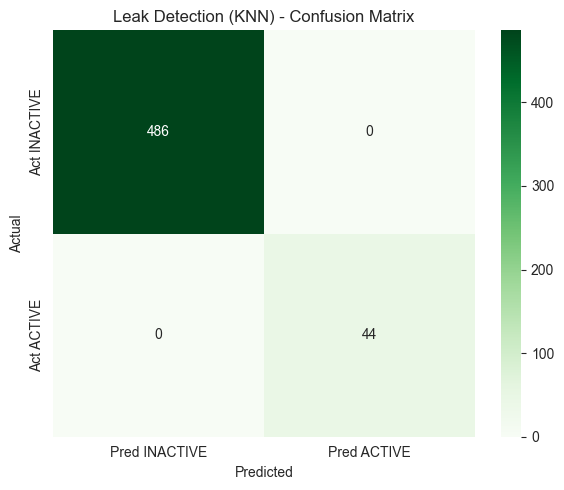

In [35]:
cm_leak = confusion_matrix(y_test_leak, y_pred_leak)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_leak, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred INACTIVE', 'Pred ACTIVE'],
            yticklabels=['Act INACTIVE', 'Act ACTIVE'])
plt.title('Leak Detection (KNN) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('model/leak_knn_confusion_matrix.png')
print("Saved confusion matrix as 'leak_knn_confusion_matrix.png'.")
print("=" * 50)

print("\n✅ All tasks complete using KNN.")